In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import cKDTree
from tqdm import tqdm

In [4]:
#Data normalization function
def normalize_dataframe(df, columns_to_normalize):
    # Create a copy of the dataframe
    df_normalized = df.copy()

    # Replace missing values with 0 in the selected columns
    #df_normalized[columns_to_normalize] = df_normalized[columns_to_normalize].fillna(0)

    # Normalize selected columns
    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(df_normalized[columns_to_normalize].values)
    df_normalized[columns_to_normalize] = scaled_values

    return df_normalized

In [ ]:
!gdown "https://drive.google.com/uc?id=1YgFojGNLM4nmagc0ALMCCT6fjmlzxNec"

full_df = pd.read.csv('./full_df_for_classification.csv')

In [22]:
selected_features = [
#'Local_Cell_Density',
 'Speed',
 'Motion_Angle_Z',
 'Motion_Angle_Y',
 'Motion_Angle_X',
 'Acceleration',
 'DISPLACEMENT_Z_ABS',
 'DISPLACEMENT_Z_SUMMED',
 'Displacement',
 'Directional_Change_Abs',
 'Displacement_summed',	
 'Directional_Change_Summed',
 'angle_difference',
 'angle_difference_summed',
 'Distance_Cell_mask',
 'Radial_Angle_Z',
 'mem_Radial_Angle_Z',
 'nuc_Radius',
 'nuc_Eccentricity_Comp_First',
 'nuc_Eccentricity_Comp_Second',
 'nuc_Eccentricity_Comp_Third',
 'nuc_Cell_Axis_Z',
 'mem_Radius',
 'mem_Eccentricity_Comp_First',
 'mem_Eccentricity_Comp_Second',
 'mem_Eccentricity_Comp_Third',
 'mem_Surface_Area',
 'mem_Cell_Axis_Z',
 'mem_2d_area',
 'mem_2d_eccentricity',
 'mem_2d_solidity',
 'mem_2d_extent',
 'mem_nuc_offset']
 #'nucleus_shape_feature_distance',	
 #'membrane_shape_feature_distance',
 #'movement_feature_distance']

In [23]:
columns_to_normalize = [
#'Local_Cell_Density', 
 'Speed',
 'Acceleration',
 'Motion_Angle_Z',
 'Motion_Angle_Y',
 'Motion_Angle_X',
 'DISPLACEMENT_Z',
 'DISPLACEMENT_Z_ABS',
 'DISPLACEMENT_Z_SUMMED',
 'Displacement',
 'Edge_xy_angle',
 'Directional_Change',
 'Directional_Change_Abs',
 'Displacement_summed',
 'Directional_Change_Summed',
 'nuc_Radius',
 'nuc_Surface_Area',
 'nuc_Eccentricity_Comp_First',
 'nuc_Eccentricity_Comp_Second',
 'nuc_Eccentricity_Comp_Third',
 'nuc_Cell_Axis_Z',
 'nuc_Cell_Axis_Y',
 'nuc_Cell_Axis_X',
 'mem_nuc_offset',
 'mem_Radius',
 'mem_Surface_Area',
 'mem_Eccentricity_Comp_First',
 'mem_Eccentricity_Comp_Second',
 'mem_Eccentricity_Comp_Third',
 'mem_Cell_Axis_Z',
 'mem_Cell_Axis_Y',
 'mem_Cell_Axis_X',
 'mem_2d_area',
 'mem_2d_perimeter',
 'mem_2d_eccentricity',
 'mem_2d_solidity',
 'mem_2d_extent',
 'mem_2d_axis_major_length',
 'mem_2d_axis_minor_length',
 'mem_2d_feret_diameter_max',
 'Distance_Cell_mask',
 'POSITION_Z_norm',
 'Radial_Angle_Z',
 'Radial_Angle_Y',
 'Radial_Angle_X',
 #'MSD',
# 'mem_Radial_Angle_Z',
# 'centroid_to_cell_angle',
 'angle_difference',
 'angle_difference_summed']
#,
# 'nucleus_shape_feature_distance',
# 'movement_feature_distance']

In [24]:
# The features are z normalized for training
full_df_normalized = normalize_dataframe(full_df, columns_to_normalize)

In [25]:
full_df2 = full_df_normalized[full_df_normalized['cell_type'] != 'unknown'].dropna(subset=columns_to_normalize)

In [26]:
# Count unique t_hours per Track ID and cell_type
track_t_hours_counts = full_df2[full_df2['annotation']  == 'manual'].groupby(['cell_type', 'Spot track ID relabelled'])['t_hours'].nunique().reset_index(name='unique_t_hours')

# Find the Track ID with the highest unique t_hours count per cell_type
result = track_t_hours_counts.loc[track_t_hours_counts.groupby('cell_type')['unique_t_hours'].idxmax(), ['cell_type', 'Spot track ID relabelled', 'unique_t_hours']]


In [27]:
result

cell_type  Spot track ID relabelled  unique_t_hours
5       basal                       357             357
23     goblet                      2399             243
60         ic                       218             325
124       mcc                        48             308
254       ssc                      1960             218

In [28]:
full_df2[full_df2['Spot track ID relabelled'] == 357]['Track ID_y'].value_counts()

35726     222
35725     207
35712     103
35724     101
35711      87
35737      85
35723      74
357310     64
35739      63
35738      42
35700      16
Name: Track ID_y, dtype: int64

In [29]:
full_df2[full_df2['Spot track ID relabelled'] == 2399]['Track ID_y'].value_counts()

239911    163
239912    162
239900     69
Name: Track ID_y, dtype: int64

In [30]:
full_df2[(full_df2['Spot track ID relabelled'] == 218) & (full_df2['cell_type'] == 'ic')]['Track ID_y'].value_counts()

21823    242
21811     71
21800     12
Name: Track ID_y, dtype: int64

In [31]:
full_df2[full_df2['Spot track ID relabelled'] == 48]['Track ID_y'].value_counts()

4812    231
4811    199
4800     62
Name: Track ID_y, dtype: int64

In [32]:
full_df2[full_df2['Spot track ID relabelled'] == 1960]['Track ID_y'].value_counts()

196012     86
196011     78
1960314    30
196024     28
196000     24
196025     24
196026     22
196023     15
196037     14
196038     10
196039      9
1960311     8
1960313     8
1960310     3
1960312     3
Name: Track ID_y, dtype: int64

In [33]:
# hand-selecting lineages so that daughter cells match mother cells, but also that the lineage is as long as possible
selected_df = full_df2[full_df2['Track ID_y'].isin([35700, 35712, 35725, 239900, 239911, 21800, 21811, 21823, 4800, 4812, 196000, 196011, 196024, 196037])]

In [34]:
selected_df['cell_type'].value_counts()

basal     326
ic        325
mcc       293
goblet    232
ssc       144
Name: cell_type, dtype: int64

In [35]:
feature_categories = {'nucleus_shape' : ['nuc_Radius',
 'nuc_Eccentricity_Comp_First',
 'nuc_Eccentricity_Comp_Second',
 'nuc_Eccentricity_Comp_Third',
 'nuc_Cell_Axis_Z',
 'mem_nuc_offset'],

'membrane_shape' : ['mem_Radius',
 'mem_Eccentricity_Comp_First',
 'mem_Eccentricity_Comp_Second',
 'mem_Eccentricity_Comp_Third',
 'mem_Surface_Area',
 'mem_Cell_Axis_Z',
 'mem_2d_area',
 'mem_2d_eccentricity',
 'mem_2d_solidity',
 'mem_2d_extent'],

'movement' : ['Speed',
 'Motion_Angle_Z',
 'Motion_Angle_Y',
 'Motion_Angle_X',
 'Acceleration',
 'DISPLACEMENT_Z_ABS',
'DISPLACEMENT_Z_SUMMED',
'Displacement', 
'Directional_Change_Abs',
'Displacement_summed',
'Directional_Change_Summed',
 'angle_difference',
 'angle_difference_summed'],

'position' : ['Local_Cell_Density',
 'Distance_Cell_mask',
 'Radial_Angle_Z',
 'mem_Radial_Angle_Z'],
}

In [36]:
full_df_normalized_cropped = full_df_normalized.dropna(subset=columns_to_normalize)
full_df_normalized_cropped2 = full_df_normalized_cropped[columns_to_normalize]

In [38]:
[feature for feature in selected_features if feature in feature_categories['membrane_shape']]

['mem_Radius',
 'mem_Eccentricity_Comp_First',
 'mem_Eccentricity_Comp_Second',
 'mem_Eccentricity_Comp_Third',
 'mem_Surface_Area',
 'mem_Cell_Axis_Z',
 'mem_2d_area',
 'mem_2d_eccentricity',
 'mem_2d_solidity',
 'mem_2d_extent']

In [39]:
random_choices = np.random.choice(full_df_normalized_cropped['Spot track ID relabelled'].value_counts()[full_df_normalized_cropped['Spot track ID relabelled'].value_counts() > 200].index.to_list(), size=3, replace=False)

random_choices 


array([3757, 1705, 1468])

In [40]:
full_df_normalized_cropped[full_df_normalized_cropped['Spot track ID relabelled'] == 317]['Track ID_y'].value_counts()

31712    215
31711    144
31700    109
31724     77
31723     45
Name: Track ID_y, dtype: int64

In [41]:
full_df_normalized_cropped[(full_df_normalized_cropped['Spot track ID relabelled'] == 317) & (full_df_normalized_cropped['Track ID_y'] == 31724)]

Unnamed: 0      ID  Spot source ID  Track ID_x  Track ID_y  Spot frame  \
62601       62601  461567        456749.0      5822.0       31724         273   
62602       62602  462859        461567.0      5822.0       31724         274   
62603       62603  465735        462859.0      5822.0       31724         275   
62604       62604  470092        465735.0      5822.0       31724         276   
62605       62605  472903        470092.0      5822.0       31724         277   
...           ...     ...             ...         ...         ...         ...   
62683       62683  730613        726858.0      5822.0       31724         355   
62684       62684  733875        730613.0      5822.0       31724         356   
62685       62685  738364        733875.0      5822.0       31724         357   
62686       62686  739446        738364.0      5822.0       31724         358   
62687       62687  744688        739446.0      5822.0       31724         359   

           t    t_hours   POSITION_X  POSITION_Y  ...  Directional_Change_Abs  \
62601  273.0  14.965833  1195.758530  607.519419  ...                0.773482   
62602  274.0  15.048889  1193.775022  607.559327  ...                2.204036   
62603  275.0  15.131944  1192.867218  607.946663  ...               -0.631391   
62604  276.0  15.215000  1191.076649  607.429813  ...                2.832457   
62605  277.0  15.298056  1190.179495  607.575727  ...                2.993211   
...      ...        ...          ...         ...  ...                     ...   
62683  355.0  21.776389  1244.701146  593.245848  ...               -0.151707   
62684  356.0  21.859444  1244.846858  594.056371  ...               -0.172845   
62685  357.0  21.942500  1245.546918  594.084348  ...                0.012675   
62686  358.0  22.025556  1246.126404  594.520546  ...               -0.483868   
62687  359.0  22.108611  1246.539692  594.610608  ...               -0.599835   

       Displacement_summed  Directional_Change_Summed  centroid_X  centroid_Y  \
62601            -0.163076                   1.469276  778.124276  742.131931   
62602            -0.163076                   1.469276  778.249292  744.348995   
62603            -0.163076                   1.469276  775.781808  744.324790   
62604            -0.163076                   1.469276  778.523677  745.206507   
62605            -0.033094                   1.478701  775.928902  741.036223   
...                    ...                        ...         ...         ...   
62683            -1.059251                  -0.871173  780.830608  763.539315   
62684            -1.121606                  -0.999576  781.936286  763.705385   
62685            -1.121606                  -0.999576  778.139382  763.416981   
62686            -1.121606                  -0.999576  777.780631  761.513070   
62687            -1.121606                  -0.999576  780.310762  763.136915   

       centroid_to_cell_angle  angle_difference  angle_difference_summed  \
62601              -17.865249          0.136840                 0.658848   
62602              -18.221370          1.985377                 0.658848   
62603              -18.106652          2.225090                 0.658848   
62604              -18.467320          1.637798                 0.658848   
62605              -17.857557          2.153193                 0.748728   
...                       ...               ...                      ...   
62683              -20.158904         -0.487055                -0.960827   
62684              -20.127044          0.734134                -1.051664   
62685              -19.914464         -0.809816                -1.051664   
62686              -19.624109         -0.126729                -1.051664   
62687              -19.873244         -0.611914                -1.051664   

       nucleus_shape_feature_distance  movement_feature_distance  
62601                        4.419448                 861.786656  
62602                        3.597600    

In [42]:
full_df_normalized_cropped[full_df_normalized_cropped['Spot track ID relabelled'] == 1969]['Track ID_y'].value_counts()

196900    209
Name: Track ID_y, dtype: int64

In [43]:
full_df_normalized_cropped[full_df_normalized_cropped['Spot track ID relabelled'] == 3449]['Track ID_y'].value_counts()

344900    229
Name: Track ID_y, dtype: int64

In [44]:
random_choices_tracklets = [31700, 31711, 31724, 196900, 344900]

In [45]:
import matplotlib.patches as mpatches

In [46]:
import matplotlib as mpl

# Set global font style and sizes      
mpl.rcParams['font.size'] = 16                 # Base font size
mpl.rcParams['axes.titlesize'] = 16            # Title font size
mpl.rcParams['axes.labelsize'] = 16            # Axis label font size
mpl.rcParams['xtick.labelsize'] = 16           # X-tick font size
mpl.rcParams['ytick.labelsize'] = 16           # Y-tick font size
mpl.rcParams['legend.fontsize'] = 14            # Legend font size
mpl.rcParams['figure.titlesize'] = 16          # Figure title font size

In [47]:
from tqdm import tqdm

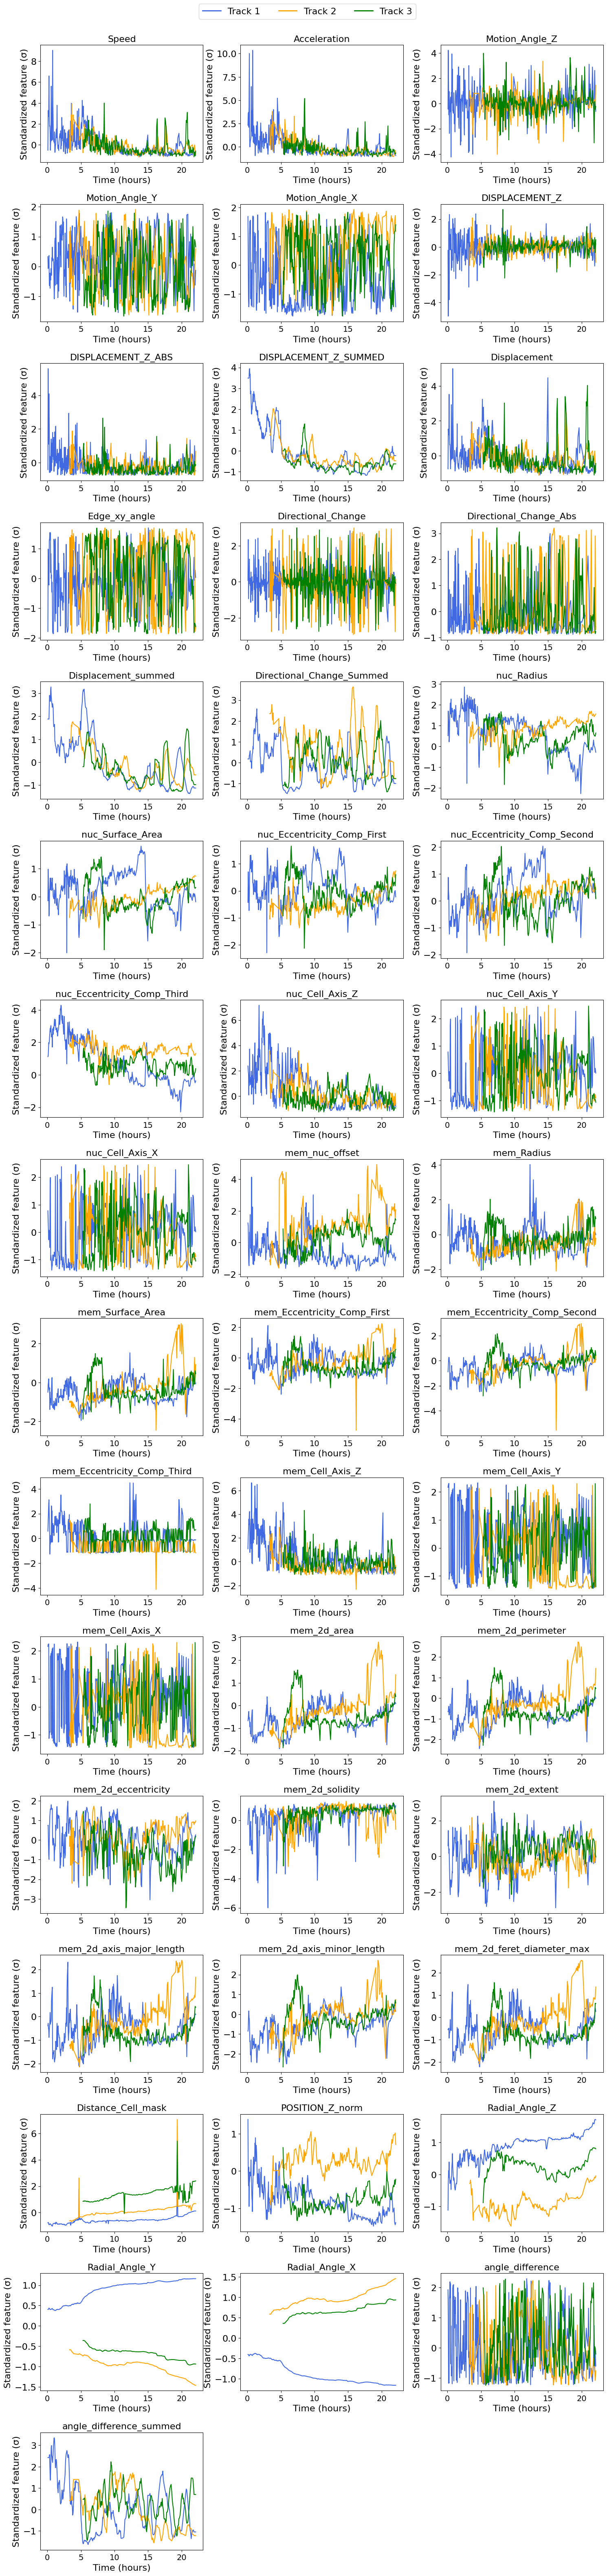

In [48]:
from matplotlib.lines import Line2D

# Subset and sort data
df_selected = full_df_normalized_cropped[
    full_df_normalized_cropped['Track ID_y'].isin(random_choices_tracklets)
]
df_selected = df_selected.sort_values(['Spot track ID relabelled', 't_hours']).reset_index(drop=True)

# Define grid
num_features = len(columns_to_normalize)
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4), sharex=False)
axes = axes.flatten()

# Define color and label mappings
track_ids = sorted(df_selected['Spot track ID relabelled'].unique())
custom_labels = ['Track 1', 'Track 2', 'Track 3']
custom_colors = ['royalblue', 'orange', 'green']
label_map = dict(zip(track_ids, custom_labels))
color_map = dict(zip(track_ids, custom_colors))

# Plot each feature
for i, feature in enumerate(columns_to_normalize):
    ax = axes[i]
    sns.lineplot(
        data=df_selected,
        x='t_hours', y=feature,
        hue='Spot track ID relabelled',
        ax=ax,
        palette=color_map,
        legend=False
    )

    ax.set_title(f'{feature}')
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Standardized feature (σ)')

    # Show x-tick labels explicitly
    ax.tick_params(axis='x', labelsize=14)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Manually create legend
legend_elements = [
    Line2D([0], [0], color=color_map[tid], lw=2, label=label_map[tid])
    for tid in track_ids
]

fig.legend(
    handles=legend_elements,
    loc='upper center',
    bbox_to_anchor=(0.5, 0.99),
    ncol=len(track_ids),
    fontsize=16
)

plt.tight_layout(rect=[0, 0, 1, 0.98])  # Make space for legend
plt.savefig('FigS2.pdf')
plt.show()

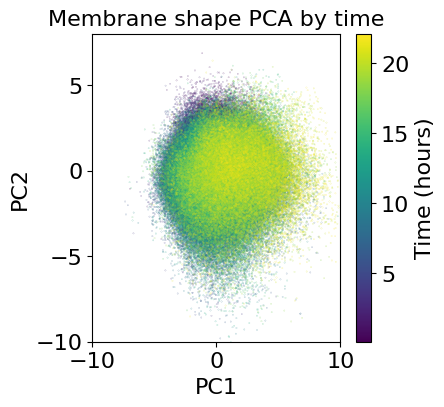

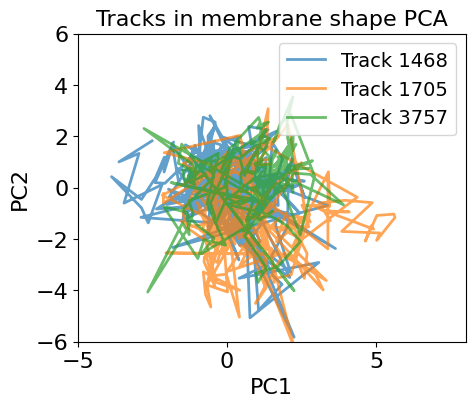

C:\Users\ghr283\AppData\Local\Temp\ipykernel_27060\433742111.py:75: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('plots_15_03/mem_shape_PCA_celltypes.pdf', dpi=300, format='pdf', bbox_inches='tight')
C:\Users\ghr283\AppData\Local\Temp\ipykernel_27060\433742111.py:75: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('plots_15_03/mem_shape_PCA_celltypes.pdf', dpi=300, format='pdf', bbox_inches='tight')
c:\Users\ghr283\Anaconda3\envs\kapoorlabsenv3\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


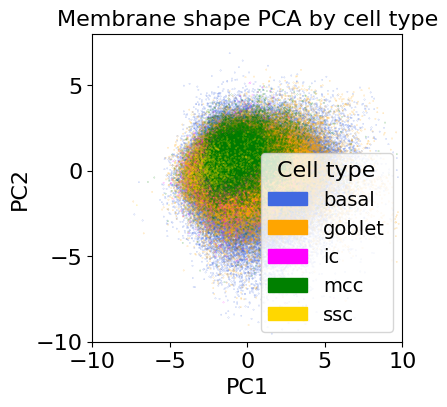

In [49]:
# Fit and transform PCA
pca = PCA(n_components=2)
mem_shape_pca_result = pca.fit_transform(full_df_normalized_cropped2[[feature for feature in selected_features if feature in feature_categories['membrane_shape']]])  # Drop categorical column

# Convert PCA results to DataFrame
pca_df = pd.DataFrame(mem_shape_pca_result, columns=['PC1', 'PC2'])

pca_df['t_hours'] = full_df_normalized_cropped['t_hours'].values
pca_df['Spot track ID relabelled'] = full_df_normalized_cropped['Spot track ID relabelled'].values
pca_df['cell_type'] = full_df_normalized_cropped['cell_type'].values

pca_df_selected_annotated = pca_df[(pca_df['cell_type'] != 'unknown')]

pca_df_selected_annotated = pca_df_selected_annotated.sort_values(['cell_type', 't_hours']).reset_index(drop=True)

pca_df_selected = pca_df[(pca_df['Spot track ID relabelled'].isin(random_choices))]

pca_df_selected = pca_df_selected.sort_values(['Spot track ID relabelled', 't_hours']).reset_index(drop=True)

plt.figure(figsize=(4, 4))
scatter = plt.scatter(
    pca_df['PC1'], pca_df['PC2'], 
    s=0.01,  # Smaller point size
    c=pca_df['t_hours'],  # Color by time
    cmap='viridis',
    rasterized = True
)

plt.colorbar(label='Time (hours)')  # Add color legend for time
plt.title('Membrane shape PCA by time')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(False)
plt.xlim((-10,10))
plt.ylim((-10,8))
plt.savefig('plots_15_03/mem_shape_PCA.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(5, 4))

for track_id, group in pca_df_selected.groupby('Spot track ID relabelled'):  
    plt.plot(group["PC1"], group["PC2"], label=f'Track {track_id}', linewidth=2, alpha=0.7)

plt.title('Tracks in membrane shape PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(False)
plt.xlim((-5,8))
plt.ylim((-6,6))
plt.legend()
plt.savefig('plots_15_03/mem_shape_PCA_tracks.pdf')
plt.show()

# Define color mapping for cell types
cell_type_colors = {'basal': 'royalblue', 'goblet': 'orange', 'ic': 'magenta', 'mcc': 'green', 'ssc': 'gold'}

plt.figure(figsize=(4, 4))
scatter = plt.scatter(
    pca_df_selected_annotated['PC1'], pca_df_selected_annotated['PC2'], 
    s=0.01,  # Smaller point size
    c=pca_df_selected_annotated['cell_type'].map(cell_type_colors),  # Color by cell type
    rasterized = True
)

# Create legend handles
legend_patches = [mpatches.Patch(color=color, label=ctype) for ctype, color in cell_type_colors.items()]
plt.legend(handles=legend_patches, title="Cell type", frameon=True)

plt.title('Membrane shape PCA by cell type')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(False)
plt.xlim((-10,10))
plt.ylim((-10,8))
plt.savefig('plots_15_03/mem_shape_PCA_celltypes.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()


In [50]:
import umap

In [ ]:
umap_model = umap.UMAP(n_components=2, random_state=42)
mem_shape_umap_result = umap_model.fit_transform(
    full_df_normalized_cropped2[[feature for feature in selected_features if feature in feature_categories['membrane_shape']]]
)

# Convert PCA results to DataFrame
umap_df = pd.DataFrame(mem_shape_umap_result, columns=['UMAP1', 'UMAP2'])

umap_df['t_hours'] = full_df_normalized_cropped['t_hours'].values
umap_df['Spot track ID relabelled'] = full_df_normalized_cropped['Spot track ID relabelled'].values
umap_df['cell_type'] = full_df_normalized_cropped['cell_type'].values

umap_df_selected_annotated = umap_df[(umap_df['cell_type'] != 'unknown')]

umap_df_selected_annotated = umap_df_selected_annotated.sort_values(['cell_type', 't_hours']).reset_index(drop=True)

umap_df_selected = umap_df[(umap_df['Spot track ID relabelled'].isin(random_choices))]

umap_df_selected = umap_df_selected.sort_values(['Spot track ID relabelled', 't_hours']).reset_index(drop=True)

plt.scatter(
    umap_df['UMAP1'], umap_df['UMAP2'],
    c=umap_df['t_hours'],
    cmap='viridis',
    s=0.01,
    rasterized=True
)

plt.colorbar(label='Time (hours)')  # Add color legend for time
plt.title('Membrane shape UMAP by time')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.grid(False)
#plt.xlim((-10,10))
#plt.ylim((-10,8))
#plt.savefig('plots_15_03/mem_shape_PCA.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(5, 4))

for track_id, group in umap_df_selected.groupby('Spot track ID relabelled'):
    plt.plot(group["UMAP1"], group["UMAP2"], linewidth=2, alpha=0.7)

plt.title('Tracks in membrane shape UMAP')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.grid(False)
#plt.xlim((-5,8))
#plt.ylim((-6,6))
plt.legend()
#plt.savefig('plots_15_03/mem_shape_PCA_tracks.pdf')
plt.show()

# Define color mapping for cell types
cell_type_colors = {'basal': 'royalblue', 'goblet': 'orange', 'ic': 'magenta', 'mcc': 'green', 'ssc': 'gold'}

plt.figure(figsize=(4, 4))
scatter = plt.scatter(
    umap_df_selected_annotated['UMAP1'], pca_df_selected_annotated['UMAP2'], 
    s=0.01,  # Smaller point size
    c=umap_df_selected_annotated['cell_type'].map(cell_type_colors),  # Color by cell type
    rasterized = True
)

# Create legend handles
legend_patches = [mpatches.Patch(color=color, label=ctype) for ctype, color in cell_type_colors.items()]
plt.legend(handles=legend_patches, title="Cell type", frameon=True)

plt.title('Membrane shape UMAP by cell type')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.grid(False)
#plt.xlim((-10,10))
#plt.ylim((-10,8))
#plt.savefig('plots_15_03/mem_shape_PCA_celltypes.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()


c:\Users\ghr283\Anaconda3\envs\kapoorlabsenv3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ghr283\Anaconda3\envs\kapoorlabsenv3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


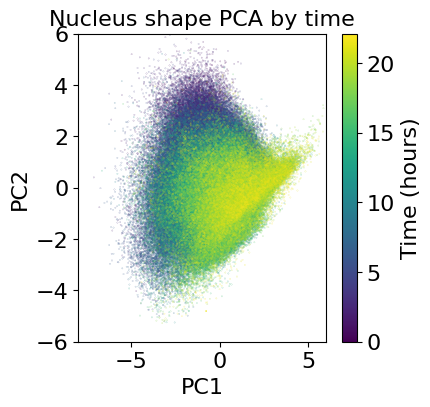

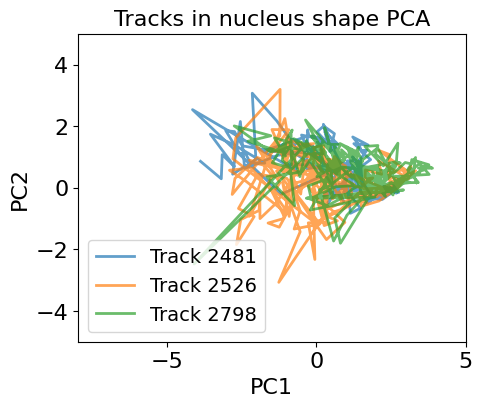

C:\Users\ghr283\AppData\Local\Temp\ipykernel_25888\1657263375.py:75: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('plots_15_03/nuc_shape_PCA_celltypes.pdf', dpi=300, format='pdf', bbox_inches='tight')
C:\Users\ghr283\AppData\Local\Temp\ipykernel_25888\1657263375.py:75: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('plots_15_03/nuc_shape_PCA_celltypes.pdf', dpi=300, format='pdf', bbox_inches='tight')
c:\Users\ghr283\Anaconda3\envs\kapoorlabsenv3\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


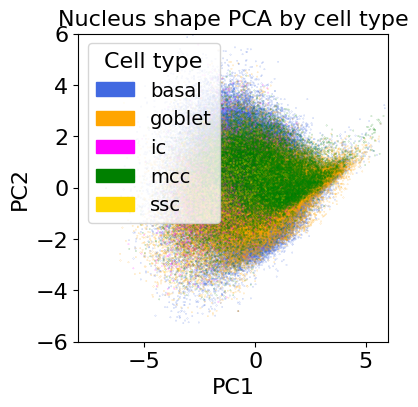

In [28]:
# Fit and transform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(full_df_normalized_cropped2[[feature for feature in selected_features if feature in feature_categories['nucleus_shape']]])  # Drop categorical column

# Convert PCA results to DataFrame
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

pca_df['t_hours'] = full_df_normalized_cropped['t_hours'].values
pca_df['Spot track ID relabelled'] = full_df_normalized_cropped['Spot track ID relabelled'].values
pca_df['cell_type'] = full_df_normalized_cropped['cell_type'].values

pca_df_selected_annotated = pca_df[(pca_df['cell_type'] != 'unknown')]

pca_df_selected_annotated = pca_df_selected_annotated.sort_values(['cell_type', 't_hours']).reset_index(drop=True)

pca_df_selected = pca_df[(pca_df['Spot track ID relabelled'].isin(random_choices))]

pca_df_selected = pca_df_selected.sort_values(['Spot track ID relabelled', 't_hours']).reset_index(drop=True)

plt.figure(figsize=(4, 4))
scatter = plt.scatter(
    pca_df['PC1'], pca_df['PC2'], 
    s=0.01,  # Smaller point size
    c=pca_df['t_hours'],  # Color by time
    cmap='viridis',
    rasterized = True
)

plt.colorbar(label='Time (hours)')  # Add color legend for time
plt.title('Nucleus shape PCA by time')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(False)
plt.xlim((-8,6))
plt.ylim((-6,6))
plt.savefig('plots_15_03/nuc_shape_PCA.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(5, 4))

for track_id, group in pca_df_selected.groupby('Spot track ID relabelled'):  
    plt.plot(group["PC1"], group["PC2"], label=f'Track {track_id}', linewidth=2, alpha=0.7)

plt.title('Tracks in nucleus shape PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(False)
plt.xlim((-8,5))
plt.ylim((-5,5))
plt.legend()
plt.savefig('plots_15_03/nuc_shape_PCA_tracks.pdf')
plt.show()

# Define color mapping for cell types
cell_type_colors = {'basal': 'royalblue', 'goblet': 'orange', 'ic': 'magenta', 'mcc': 'green', 'ssc': 'gold'}

plt.figure(figsize=(4, 4))
scatter = plt.scatter(
    pca_df_selected_annotated['PC1'], pca_df_selected_annotated['PC2'], 
    s=0.01,  # Smaller point size
    c=pca_df_selected_annotated['cell_type'].map(cell_type_colors),  # Color by cell type
    rasterized = True
)

# Create legend handles
legend_patches = [mpatches.Patch(color=color, label=ctype) for ctype, color in cell_type_colors.items()]
plt.legend(handles=legend_patches, title="Cell type", frameon=True)

plt.title('Nucleus shape PCA by cell type')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(False)
plt.xlim((-8,6))
plt.ylim((-6,6))
plt.savefig('plots_15_03/nuc_shape_PCA_celltypes.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()

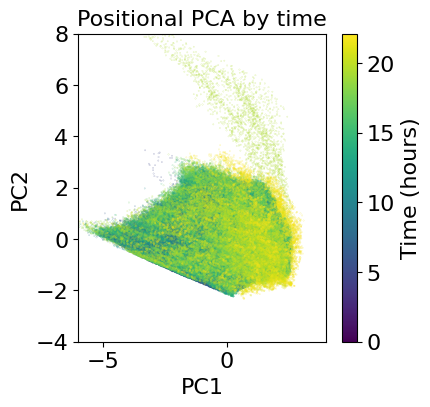

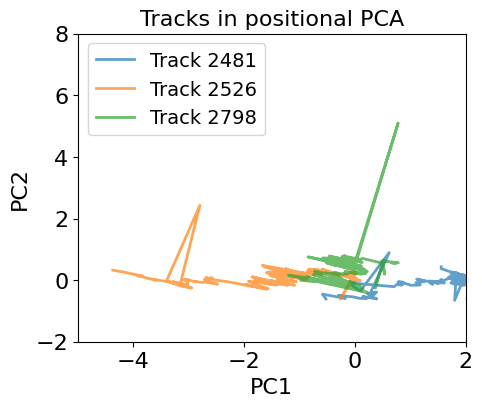

C:\Users\ghr283\AppData\Local\Temp\ipykernel_25888\2234303604.py:75: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('plots_15_03/position_PCA_celltypes.pdf', dpi=300, format='pdf', bbox_inches='tight')
C:\Users\ghr283\AppData\Local\Temp\ipykernel_25888\2234303604.py:75: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('plots_15_03/position_PCA_celltypes.pdf', dpi=300, format='pdf', bbox_inches='tight')
c:\Users\ghr283\Anaconda3\envs\kapoorlabsenv3\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


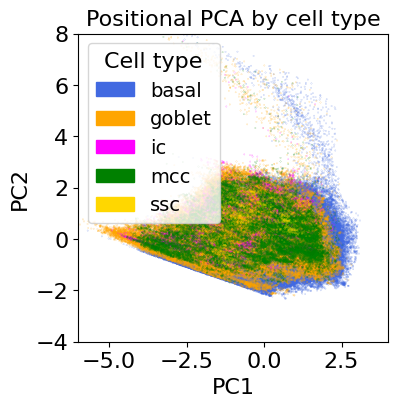

In [ ]:
# Fit and transform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(full_df_normalized_cropped2[[feature for feature in selected_features if feature in feature_categories['position']]])  # Drop categorical column

# Convert PCA results to DataFrame
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

pca_df['t_hours'] = full_df_normalized_cropped['t_hours'].values
pca_df['Spot track ID relabelled'] = full_df_normalized_cropped['Spot track ID relabelled'].values
pca_df['cell_type'] = full_df_normalized_cropped['cell_type'].values

pca_df_selected_annotated = pca_df[(pca_df['cell_type'] != 'unknown')]

pca_df_selected_annotated = pca_df_selected_annotated.sort_values(['cell_type', 't_hours']).reset_index(drop=True)

pca_df_selected = pca_df[(pca_df['Spot track ID relabelled'].isin(random_choices))]

pca_df_selected = pca_df_selected.sort_values(['Spot track ID relabelled', 't_hours']).reset_index(drop=True)

plt.figure(figsize=(4, 4))
scatter = plt.scatter(
    pca_df['PC1'], pca_df['PC2'], 
    s=0.01,  # Smaller point size
    c=pca_df['t_hours'],  # Color by time
    cmap='viridis',
    rasterized = True
)

plt.colorbar(label='Time (hours)')  # Add color legend for time
plt.title('Positional PCA by time')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(False)
plt.xlim((-6,4))
plt.ylim((-4,8))
plt.savefig('plots_15_03/position_PCA.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(5, 4))

for track_id, group in pca_df_selected.groupby('Spot track ID relabelled'):  
    plt.plot(group["PC1"], group["PC2"], label=f'Track {track_id}', linewidth=2, alpha=0.7)
    
plt.title('Tracks in positional PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(False)
plt.xlim((-5,3))
plt.ylim((-2,8))
plt.legend()
plt.savefig('plots_15_03/position_PCA_tracks.pdf')
plt.show()

# Define color mapping for cell types
cell_type_colors = {'basal': 'royalblue', 'goblet': 'orange', 'ic': 'magenta', 'mcc': 'green', 'ssc': 'gold'}

plt.figure(figsize=(4, 4))
scatter = plt.scatter(
    pca_df_selected_annotated['PC1'], pca_df_selected_annotated['PC2'], 
    s=0.01,  # Smaller point size
    c=pca_df_selected_annotated['cell_type'].map(cell_type_colors),  # Color by cell type
    rasterized = True
)

# Create legend handles
legend_patches = [mpatches.Patch(color=color, label=ctype) for ctype, color in cell_type_colors.items()]
plt.legend(handles=legend_patches, title="Cell type", frameon=True)

plt.title('Positional PCA by cell type')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(False)
plt.xlim((-6,4))
plt.ylim((-4,8))
plt.savefig('plots_15_03/position_PCA_celltypes.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()

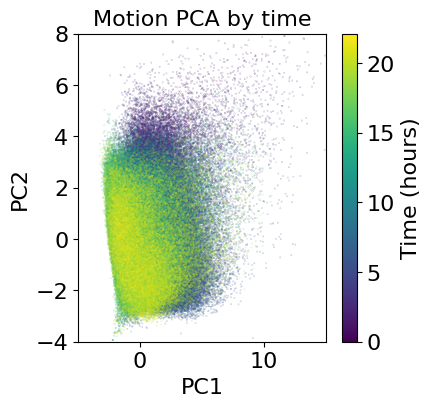

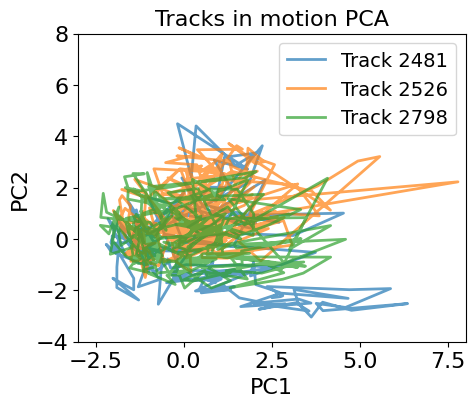

C:\Users\ghr283\AppData\Local\Temp\ipykernel_25888\826914445.py:75: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('plots_15_03/movement_PCA_celltypes.pdf', dpi=300, format='pdf', bbox_inches='tight')
C:\Users\ghr283\AppData\Local\Temp\ipykernel_25888\826914445.py:75: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('plots_15_03/movement_PCA_celltypes.pdf', dpi=300, format='pdf', bbox_inches='tight')
c:\Users\ghr283\Anaconda3\envs\kapoorlabsenv3\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


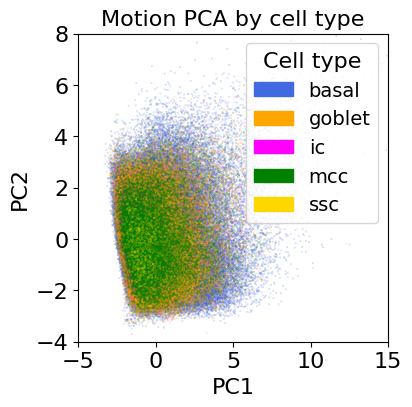

In [30]:
# Fit and transform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(full_df_normalized_cropped2[[feature for feature in selected_features if feature in feature_categories['movement']]])  # Drop categorical column

# Convert PCA results to DataFrame
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

pca_df['t_hours'] = full_df_normalized_cropped['t_hours'].values
pca_df['Spot track ID relabelled'] = full_df_normalized_cropped['Spot track ID relabelled'].values
pca_df['cell_type'] = full_df_normalized_cropped['cell_type'].values

pca_df_selected_annotated = pca_df[(pca_df['cell_type'] != 'unknown')]

pca_df_selected_annotated = pca_df_selected_annotated.sort_values(['cell_type', 't_hours']).reset_index(drop=True)

pca_df_selected = pca_df[(pca_df['Spot track ID relabelled'].isin(random_choices))]

pca_df_selected = pca_df_selected.sort_values(['Spot track ID relabelled', 't_hours']).reset_index(drop=True)

plt.figure(figsize=(4, 4))
scatter = plt.scatter(
    pca_df['PC1'], pca_df['PC2'], 
    s=0.01,  # Smaller point size
    c=pca_df['t_hours'],  # Color by time
    cmap='viridis',
    rasterized=True
)

plt.colorbar(label='Time (hours)')  # Add color legend for time
plt.title('Motion PCA by time')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(False)
plt.xlim((-5,15))
plt.ylim((-4,8))
plt.savefig('plots_15_03/movement_PCA.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(5, 4))

for track_id, group in pca_df_selected.groupby('Spot track ID relabelled'):  
    plt.plot(group["PC1"], group["PC2"], label=f'Track {track_id}', linewidth=2, alpha=0.7)
    
plt.title('Tracks in motion PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(False)
plt.xlim((-3,8))
plt.ylim((-4,8))
plt.legend()
plt.savefig('plots_15_03/movement_PCA_tracks.pdf')
plt.show()

# Define color mapping for cell types
cell_type_colors = {'basal': 'royalblue', 'goblet': 'orange', 'ic': 'magenta', 'mcc': 'green', 'ssc': 'gold'}

plt.figure(figsize=(4, 4))
scatter = plt.scatter(
    pca_df_selected_annotated['PC1'], pca_df_selected_annotated['PC2'], 
    s=0.01,  # Smaller point size
    c=pca_df_selected_annotated['cell_type'].map(cell_type_colors),  # Color by cell type
    rasterized = True
)

# Create legend handles
legend_patches = [mpatches.Patch(color=color, label=ctype) for ctype, color in cell_type_colors.items()]
plt.legend(handles=legend_patches, title="Cell type", frameon=True)

plt.title('Motion PCA by cell type')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(False)
plt.xlim((-5,15))
plt.ylim((-4,8))
plt.savefig('plots_15_03/movement_PCA_celltypes.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()

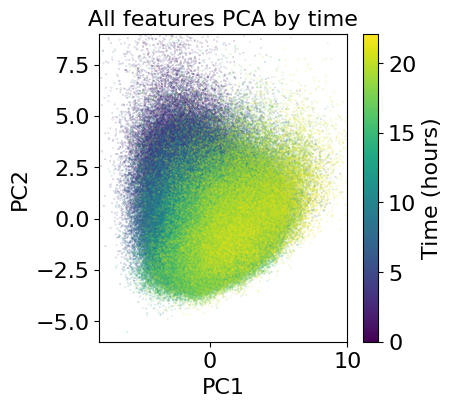

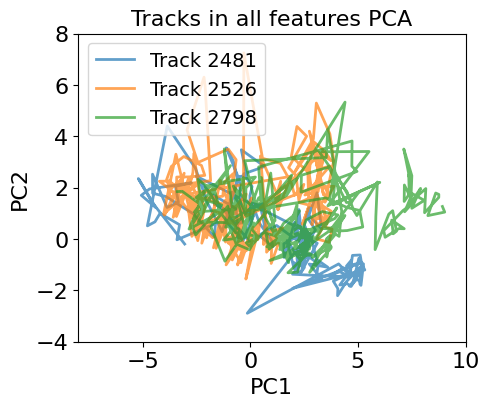

C:\Users\ghr283\AppData\Local\Temp\ipykernel_25888\497191204.py:75: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('plots_15_03/all_PCA_celltypes.pdf', dpi=300, format='pdf', bbox_inches='tight')
C:\Users\ghr283\AppData\Local\Temp\ipykernel_25888\497191204.py:75: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('plots_15_03/all_PCA_celltypes.pdf', dpi=300, format='pdf', bbox_inches='tight')
c:\Users\ghr283\Anaconda3\envs\kapoorlabsenv3\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


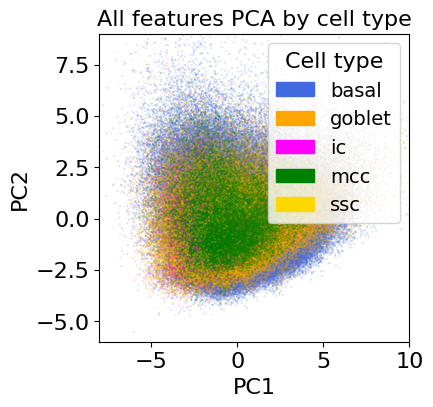

In [31]:
# Fit and transform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(full_df_normalized_cropped2)  # Drop categorical column

# Convert PCA results to DataFrame
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

pca_df['t_hours'] = full_df_normalized_cropped['t_hours'].values
pca_df['Spot track ID relabelled'] = full_df_normalized_cropped['Spot track ID relabelled'].values
pca_df['cell_type'] = full_df_normalized_cropped['cell_type'].values

pca_df_selected_annotated = pca_df[(pca_df['cell_type'] != 'unknown')]

pca_df_selected_annotated = pca_df_selected_annotated.sort_values(['cell_type', 't_hours']).reset_index(drop=True)

pca_df_selected = pca_df[(pca_df['Spot track ID relabelled'].isin(random_choices))]

pca_df_selected = pca_df_selected.sort_values(['Spot track ID relabelled', 't_hours']).reset_index(drop=True)

plt.figure(figsize=(4, 4))
scatter = plt.scatter(
    pca_df['PC1'], pca_df['PC2'], 
    s=0.01,  # Smaller point size
    c=pca_df['t_hours'],  # Color by time
    cmap='viridis',
    rasterized=True
)

plt.colorbar(label='Time (hours)')  # Add color legend for time
plt.title('All features PCA by time')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(False)
plt.xlim((-8,10))
plt.ylim((-6,9))
plt.savefig('plots_15_03/all_PCA.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(5, 4))

for track_id, group in pca_df_selected.groupby('Spot track ID relabelled'):  
    plt.plot(group["PC1"], group["PC2"], label=f'Track {track_id}', linewidth=2, alpha=0.7)
    
plt.title('Tracks in all features PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(False)
plt.xlim((-8, 10))
plt.ylim((-4, 8))
plt.legend()
plt.savefig('plots_15_03/all_PCA_tracks_new.pdf')
plt.show()

# Define color mapping for cell types
cell_type_colors = {'basal': 'royalblue', 'goblet': 'orange', 'ic': 'magenta', 'mcc': 'green', 'ssc': 'gold'}

plt.figure(figsize=(4, 4))
scatter = plt.scatter(
    pca_df_selected_annotated['PC1'], pca_df_selected_annotated['PC2'], 
    s=0.01,  # Smaller point size
    c=pca_df_selected_annotated['cell_type'].map(cell_type_colors),  # Color by cell type
    rasterized = True
)

# Create legend handles
legend_patches = [mpatches.Patch(color=color, label=ctype) for ctype, color in cell_type_colors.items()]
plt.legend(handles=legend_patches, title="Cell type", frameon=True)

plt.title('All features PCA by cell type')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(False)
plt.xlim((-8,10))
plt.ylim((-6,9))
plt.savefig('plots_15_03/all_PCA_celltypes.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()

C:\Users\ghr283\AppData\Local\Temp\ipykernel_28904\3532251113.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Cell type", frameon=True)


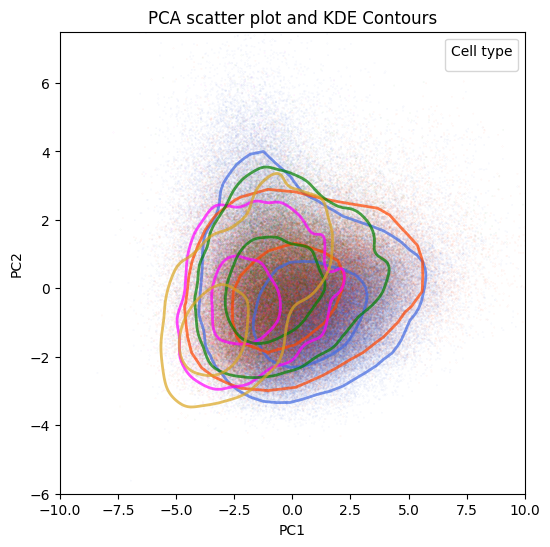

In [36]:
cell_type_colors = {'basal': 'royalblue', 'goblet': 'orangered', 'ic': 'magenta', 'mcc': 'green', 'ssc': 'goldenrod'}

plt.figure(figsize=(6, 6))

scatter = plt.scatter(
    pca_df_selected_annotated['PC1'], pca_df_selected_annotated['PC2'], 
    s=0.01,  # Smaller point size
    c=pca_df_selected_annotated['cell_type'].map(cell_type_colors),  # Color by cell type
    rasterized = True,
    alpha=0.2
)

# Loop through each cell type and plot KDE contours
for cell_type, group in pca_df_selected_annotated.groupby('cell_type'):
    sns.kdeplot(
        x=group['PC1'], y=group['PC2'], 
        color=cell_type_colors[cell_type],  # Color using the cell type colors
        fill=False,  # Only plot contours, no filled areas
        linewidths=2,  # Line thickness
        label=cell_type,  # For the legend
        levels=3,  # Show only the densest contour
        thresh=0.1,  # Threshold to plot only the high-density area
        alpha = 0.7
    )

# Set axis limits, labels, and grid
plt.title('PCA scatter plot and KDE Contours')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title="Cell type", frameon=True)
plt.grid(False)
plt.xlim((-10, 10))
plt.ylim((-6, 7.5))

# Save the plot as PDF
plt.savefig('plots_15_03/all_PCA_celltypes_kde.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()


In [133]:
from matplotlib.collections import LineCollection

C:\Users\ghr283\AppData\Local\Temp\ipykernel_7704\2797845333.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Cell Type", loc="upper right")


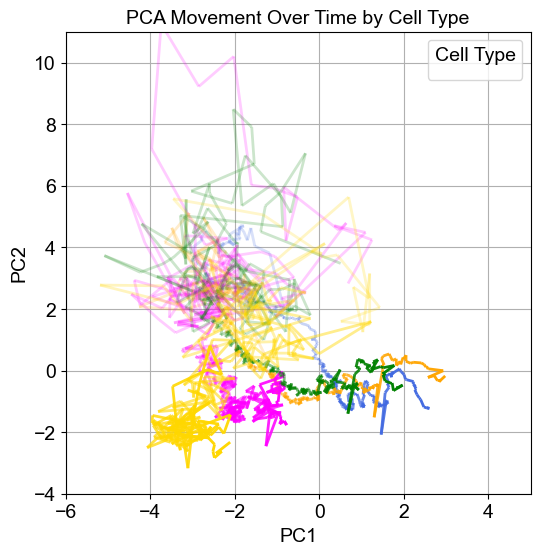

In [134]:


# Compute mean PC1 and PC2 per cell type and timepoint
pca_means = pca_df_selected_annotated.groupby(['t_hours', 'cell_type'])[['PC1', 'PC2']].mean().reset_index()

# Normalize alpha based on time (for transparency effect)
pca_means['alpha'] = (pca_means['t_hours'] / pca_means['t_hours'].max()).clip(lower=0.2)

plt.figure(figsize=(6, 6))

# Loop through each cell type
for cell_type, group in pca_means.groupby('cell_type'):
    group = group.sort_values('t_hours')  # Ensure time ordering
    
    # Extract PC1, PC2, and alpha values
    points = np.array([group["PC1"], group["PC2"]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)  # Create line segments
    
    # Normalize alpha for the line segments (skip last point since it has no next segment)
    alphas = group["alpha"].values[:-1]  
    
    # Create LineCollection with varying alpha
    lc = LineCollection(segments, cmap="gray", norm=plt.Normalize(0, 1),
                        linewidth=2, alpha=0.7, color=cell_type_colors[cell_type])
    
    # Set individual alpha per segment
    lc.set_alpha(alphas)
    
    plt.gca().add_collection(lc)  # Add the line collection to the plot

plt.title("PCA Movement Over Time by Cell Type")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cell Type", loc="upper right")
plt.grid(True)
plt.xlim((-6,5))
plt.ylim((-4,11))

plt.show()


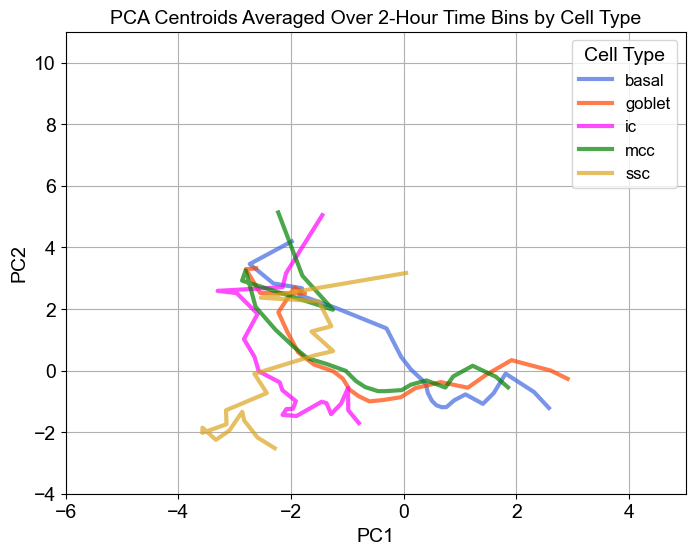

In [135]:
# Define color mapping for cell types
cell_type_colors = {'basal': 'royalblue', 'goblet': 'orangered', 'ic': 'magenta', 'mcc': 'green', 'ssc': 'goldenrod'}

# Define hour bins (e.g., 0-2, 2-4, ..., 22-24)
bin_edges = np.arange(0, 24, 1)
pca_df_selected_annotated["t_bin"] = pd.cut(pca_df_selected_annotated["t_hours"], bins=bin_edges, include_lowest=True, right=False)

# Compute mean PC1 and PC2 per time bin and cell type
pca_binned_means = pca_df_selected_annotated.groupby(['t_bin', 'cell_type'])[['PC1', 'PC2']].mean().reset_index()

plt.figure(figsize=(8, 6))

# Loop through each cell type to scatter plot the time-binned centroids
for cell_type, group in pca_binned_means.groupby('cell_type'):
    plt.plot(group["PC1"], group["PC2"], alpha=0.7, label=cell_type, linewidth = 3, color=cell_type_colors[cell_type])

# Adding labels, grid, and legend
plt.title("PCA Centroids Averaged Over 2-Hour Time Bins by Cell Type")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cell Type", loc="upper right")
plt.grid(True)
plt.xlim((-6, 5))
plt.ylim((-4, 11))

plt.show()


C:\Users\ghr283\AppData\Local\Temp\ipykernel_7704\2439761122.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


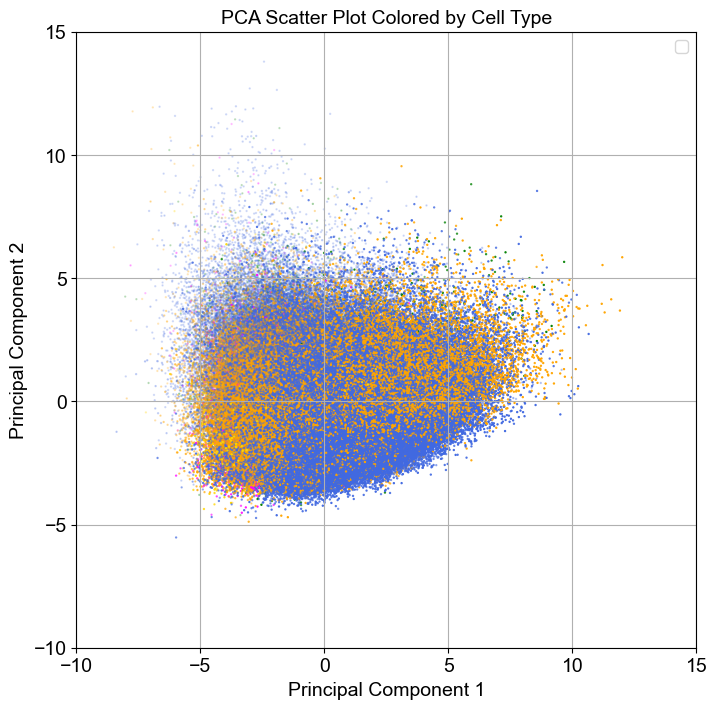

In [136]:
# Fit and transform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(full_df_normalized_cropped2)  # Drop categorical column

# Convert PCA results to DataFrame
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['cell_type'] = full_df_normalized_cropped['cell_type'].values
pca_df['t_hours'] = full_df_normalized_cropped['t_hours'].values  # Add back cell_type

# Remove rows where cell_type is 'unknown'
pca_df_cropped = pca_df[pca_df['cell_type'] != 'unknown']

# Define color mapping for cell types
cell_type_colors = {'basal': 'royalblue', 'goblet': 'orange', 'ic': 'magenta', 'mcc': 'green', 'ssc': 'gold'}

plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    pca_df_cropped['PC1'], pca_df_cropped['PC2'], 
    c=pca_df_cropped['cell_type'].map(cell_type_colors),  # Color by cell type
    s=0.5,  # Smaller point size
    alpha = (pca_df_cropped['t_hours'] / pca_df_cropped['t_hours'].max()).clip(lower=0.2)  # Normalize alpha (0 to 1)
)
plt.title('PCA Scatter Plot Colored by Cell Type')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.xlim((-10,15))
plt.ylim((-10,15))
plt.legend()
plt.show()

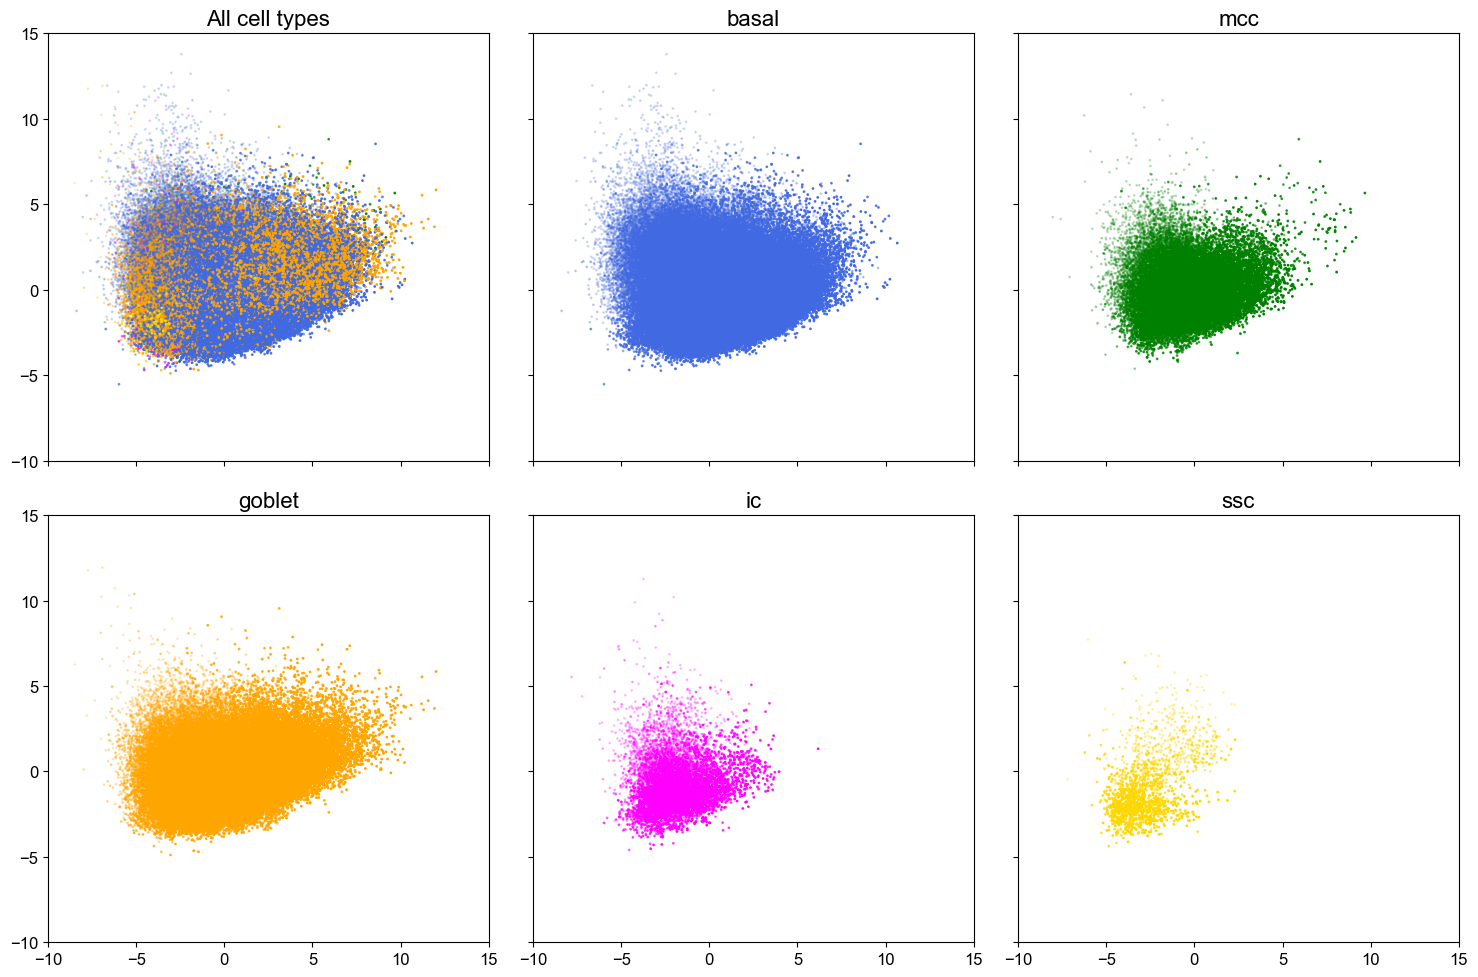

In [137]:
# Get unique cell types
cell_types = pca_df_cropped['cell_type'].unique()
num_plots = len(cell_types) + 1  # One for all + one per class

# Define subplot grid size (adjust based on number of plots)
rows = (num_plots // 3) + (num_plots % 3 > 0)  # Ensures enough rows
cols = min(3, num_plots)  # Max 3 columns per row

# Set global font size for all text elements
plt.rcParams.update({
    'font.size': 14,          # Base font size
    'axes.titlesize': 16,     # Title font size
    'axes.labelsize': 14,     # Axis labels font size
    'xtick.labelsize': 12,    # X-axis tick font size
    'ytick.labelsize': 12,    # Y-axis tick font size
    'legend.fontsize': 12     # Legend font size
})

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten to 1D for easier indexing

# Normalize alpha values (ensuring min 0.2)
alpha_values = (pca_df_cropped['t_hours'] / pca_df_cropped['t_hours'].max()).clip(lower=0.2).values  # Convert to NumPy array

# Set fixed x and y limits
x_min, x_max = -10, 15
y_min, y_max = -10, 15

# First plot: All cell types together
axes[0].scatter(
    pca_df_cropped['PC1'], pca_df_cropped['PC2'], 
    c=pca_df_cropped['cell_type'].map(cell_type_colors), 
    alpha=alpha_values, s=1
)
axes[0].set_title('All cell types')
axes[0].set_xlim(x_min, x_max)
axes[0].set_ylim(y_min, y_max)

# Individual plots for each cell type
for i, cell_type in enumerate(cell_types):
    subset_df = pca_df_cropped[pca_df_cropped['cell_type'] == cell_type]  # Filter data for the specific class
    alpha_subset = (subset_df['t_hours'] / subset_df['t_hours'].max()).clip(lower=0.2).values  # Normalize

    axes[i+1].scatter(
        subset_df['PC1'], subset_df['PC2'], 
        c=[cell_type_colors[cell_type]] * len(subset_df),  # Apply single color per class
        alpha=alpha_subset, s=1
    )
    axes[i+1].set_title(cell_type)
    axes[i+1].set_xlim(x_min, x_max)  # Set same x limits
    axes[i+1].set_ylim(y_min, y_max)  # Set same y limits

# Hide unused subplots (if num_plots < total grid size)
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [144]:
top_feature_per_category

{'nucleus_shape': 'nuc_Eccentricity_Comp_Second',
 'membrane_shape': 'mem_Surface_Area',
 'movement': 'Acceleration',
 'position': 'Radial_Angle_Z'}

In [101]:
import matplotlib as mpl

# Set global font style and sizes         
mpl.rcParams['font.size'] = 18                 # Base font size
mpl.rcParams['axes.titlesize'] = 18            # Title font size
mpl.rcParams['axes.labelsize'] = 18            # Axis label font size
mpl.rcParams['xtick.labelsize'] = 18           # X-tick font size
mpl.rcParams['ytick.labelsize'] = 18           # Y-tick font size
mpl.rcParams['legend.fontsize'] = 18            # Legend font size
mpl.rcParams['figure.titlesize'] = 18          # Figure title font size

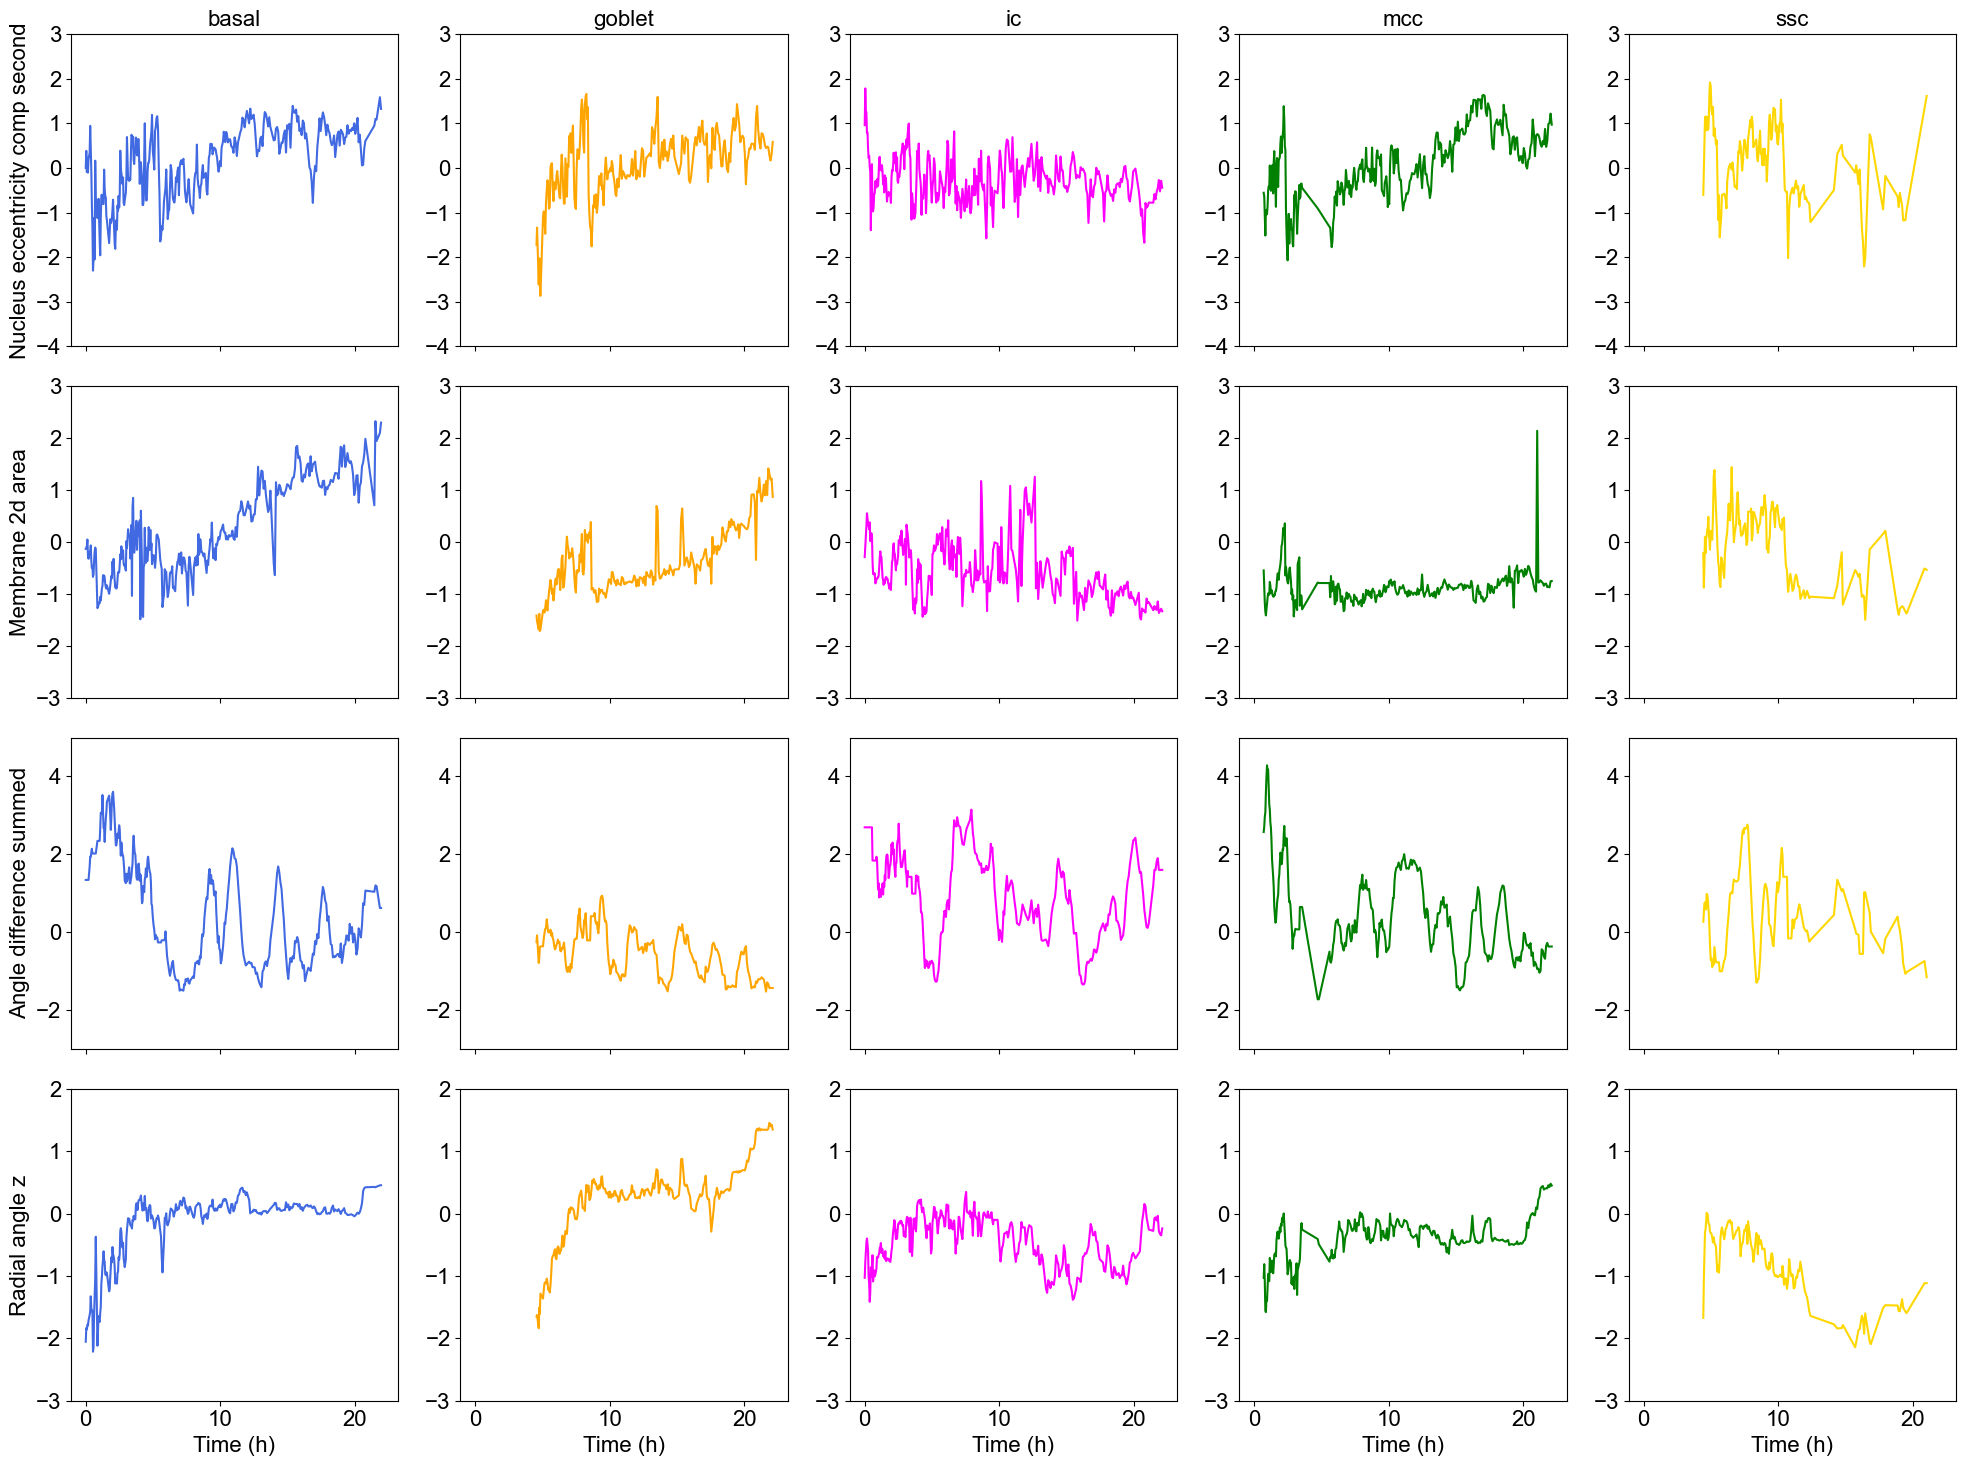

In [145]:
# Function to format feature names
def format_feature_name(feature):
    formatted = feature.replace('_', ' ')  # Replace underscores with spaces
    formatted = formatted.replace('mem', 'membrane').replace('nuc', 'nucleus')  # Replace abbreviations
    formatted = formatted.capitalize()  # Capitalize first letter, rest lowercase
    return formatted

# Define color mapping for cell types
cell_type_colors = {'basal': 'royalblue', 'goblet': 'orange', 'ic': 'magenta', 'mcc': 'green', 'ssc': 'gold'}

# Define manual y-axis limits per row
y_limits = {0: (-4, 3), 1: (-3, 3), 2: (-3, 5), 3: (-3, 2)}

# Create subplots (4 rows for categories, 5 columns for cell types)
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 15), sharex=True, sharey=False)

# Flatten axes for easier indexing
axes = axes.flatten()

# Loop through each cell type (columns)
for col_idx, (cell_type, color) in enumerate(cell_type_colors.items()):
    
    # Subset dataframe for the current cell type
    df_cell = selected_df[selected_df['cell_type'] == cell_type]
    
    # Loop through each feature category (rows)
    for row_idx, (category, feature) in enumerate(top_feature_per_category.items()):
        
        # Get the corresponding subplot
        ax = axes[row_idx * 5 + col_idx]  # 4 rows * 5 columns
        
        # Plot the highest PCA-loading feature for this category
        sns.lineplot(data=df_cell, x='t_hours', y=feature, ax=ax, color=color)

        # Set consistent y-limits for the row
        ax.set_ylim(y_limits[row_idx])

        # Increase font sizes
        ax.set_title(f"{cell_type}" if row_idx == 0 else "", fontsize=16)  # Larger title font
        ax.set_xlabel("Time (h)", fontsize=16)  # Larger x-label
        ax.set_ylabel(format_feature_name(feature) if col_idx == 0 else "", fontsize=16)  # Larger y-label

        # Increase tick label font size
        ax.tick_params(axis='both', labelsize=16)  

# Adjust layout and show the figure
plt.tight_layout()
plt.savefig("D:/for_figures/single_cell_features.pdf", bbox_inches='tight')
plt.show()

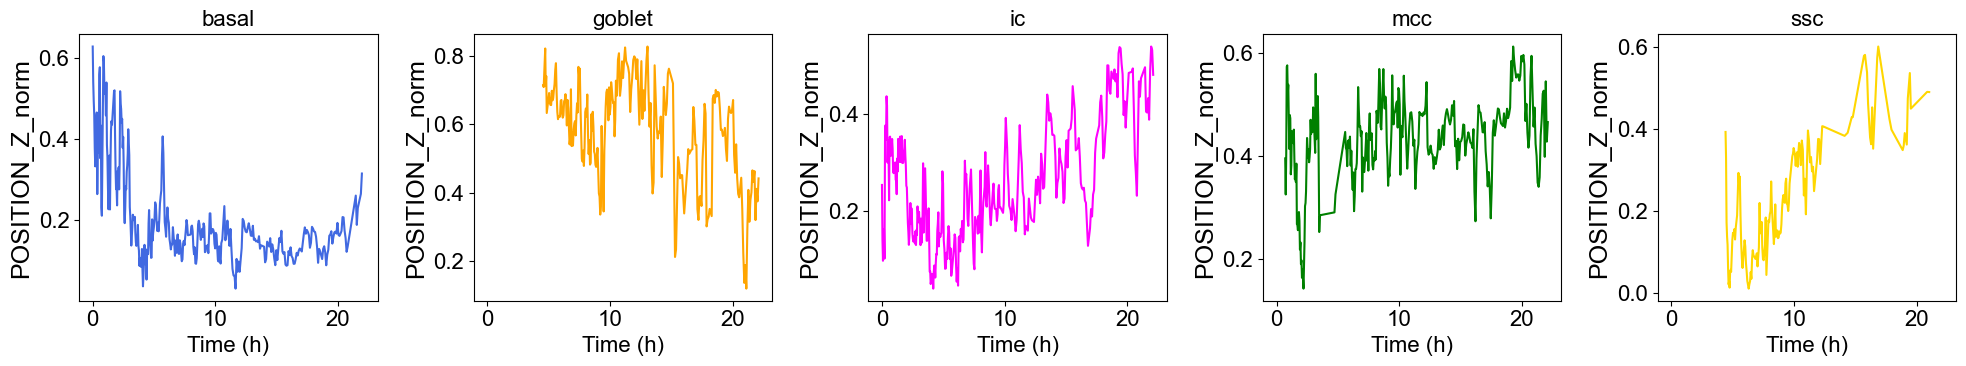

In [146]:
# Define color mapping for cell types
cell_type_colors = {'basal': 'royalblue', 'goblet': 'orange', 'ic': 'magenta', 'mcc': 'green', 'ssc': 'gold'}

# Create subplots (4 rows for categories, 5 columns for cell types)
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4), sharex=True, sharey=False)

# Flatten axes for easier indexing
axes = axes.flatten()

row_idx = 0

# Loop through each cell type (columns)
for col_idx, (cell_type, color) in enumerate(cell_type_colors.items()):
    
    # Subset dataframe for the current cell type
    df_cell = selected_df[selected_df['cell_type'] == cell_type]
        
    # Get the corresponding subplot
    ax = axes[col_idx]  # 4 rows * 5 columns
        
    # Plot the highest PCA-loading feature for this category
    sns.lineplot(data=df_cell, x='t_hours', y='POSITION_Z_norm', ax=ax, color=color)

    # Set consistent y-limits for the row
    #ax.set_ylim(y_limits[row_idx])

    # Increase font sizes
    ax.set_title(f"{cell_type}" if row_idx == 0 else "", fontsize=16)  # Larger title font
    ax.set_xlabel("Time (h)", fontsize=16)  # Larger x-label
    #ax.set_ylabel(format_feature_name(feature) if col_idx == 0 else "", fontsize=12)  # Larger y-label

    # Increase tick label font size
    ax.tick_params(axis='both', labelsize=16)  

# Adjust layout and show the figure
plt.tight_layout()
plt.show()